In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
def loadData(lang, filep = "./data_train.csv"):
    c = pd.read_csv(filep)
    c.fillna({"title":'',"abstract":''},inplace=True)
    c.dropna(inplace=True)
    for i,t,a in c[["title","abstract"]].itertuples():
        lang.addSentence(t+' '+a)
        
    return c

In [6]:
lang = Lang()
train = loadData(lang)
test = loadData(lang, "./data_test.csv")

In [7]:
train1 = train.sample(frac=0.8)
train2 = train.drop(train1.index)

In [8]:
label2int = {k : i for i,k in enumerate(train.label.unique())}
int2label = {v : k for k, v in label2int.items()}

In [9]:
len(lang.word2count)

6767

In [10]:
train.sample()

,pmid,year,title,abstract,label
89,23235213,2012,Re: Increased survival with enzalutamide in pr...,,E3


In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [12]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.out = nn.Sequential(*[nn.Linear(hidden_size, hidden_size) for i in range(n_layers-1)],nn.Linear(hidden_size, output_size))
        self.softmax = nn.LogSoftmax(dim=0)

    def forward(self, hidden):
        return self.softmax(self.out(hidden))

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    indexes.insert(0,SOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result

def variableFromLabel(label):
    result = Variable(torch.LongTensor([label2int[label]]))
    if use_cuda:
        return result.cuda()
    else:
        return result

In [14]:
def trainModel(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]

    loss = 0

    for ei in range(input_length):
        _, encoder_hidden = encoder(input_variable[ei], encoder_hidden)

    decoder_output = decoder(encoder_hidden[0][0]).unsqueeze(0)

    loss = criterion(decoder_output, target_variable)
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data

In [15]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
def trainIters(train, test, encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    plot_trainScore = []
    plot_testScore = []

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    scoreTrain, scoreTest = None, None

    for iter in range(1, n_iters + 1):
        sample = train.sample().iloc[0]
        input_variable = variableFromSentence(lang, sample.title)
        target_variable = variableFromLabel(sample.label)

        loss = trainModel(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            scoreTrain = score(train, encoder1, decoder1)
            scoreTest = score(test, encoder1, decoder1)
            print('%s (%d %d%%) %.4f %.2f %.2f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, scoreTrain, scoreTest))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            if scoreTrain :
                plot_trainScore.append(scoreTrain)
                plot_testScore.append(scoreTest)
                
            else :
                plot_trainScore.append(score(train, encoder, decoder))
                plot_testScore.append(score(test, encoder, decoder))
            plot_loss_total = 0
            scoreTrain, scoreTest = None, None

    showPlot(plot_losses)
    showPlot(list(zip(plot_trainScore,plot_testScore)))

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [18]:
def evaluate(encoder, decoder, sentence):
    input_variable = variableFromSentence(lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    for ei in range(input_length):
        _, encoder_hidden = encoder(input_variable[ei], encoder_hidden)

    decoder_output = decoder(encoder_hidden[0][0])

    return int2label[decoder_output.data.topk(1)[1][0]]

In [19]:
def evaluateRandomly(data, encoder, decoder, n=10):
    for i in range(n):
        sample = data.sample().iloc[0]
        inputSentence = sample.title
        target = sample.label
        print('>', inputSentence)
        print('=', target)
        output = evaluate(encoder, decoder, inputSentence)
        print('<', output)
        print('')

In [20]:
def score(data, encoder, decoder, n=1000):
    cpt = 0
    for i in range(n):
        sample = data.sample().iloc[0]
        inputSentence = sample.title
        target = sample.label
        output = evaluate(encoder, decoder, inputSentence)
        if output == target:
            cpt+=1
    return cpt/n

1m 2s (- 19m 38s) (100 5%) 1.1427 0.37 0.35
1m 52s (- 16m 51s) (200 10%) 1.0498 0.62 0.58
2m 43s (- 15m 28s) (300 15%) 0.9684 0.58 0.62
3m 41s (- 14m 45s) (400 20%) 0.9557 0.52 0.37
4m 33s (- 13m 39s) (500 25%) 0.9217 0.60 0.52
5m 23s (- 12m 35s) (600 30%) 0.8518 0.69 0.50
6m 15s (- 11m 37s) (700 35%) 0.7798 0.75 0.59
7m 9s (- 10m 44s) (800 40%) 0.6808 0.78 0.58
8m 1s (- 9m 48s) (900 45%) 0.6635 0.77 0.52
8m 52s (- 8m 52s) (1000 50%) 0.5189 0.84 0.57
9m 43s (- 7m 57s) (1100 55%) 0.4685 0.88 0.54
10m 38s (- 7m 5s) (1200 60%) 0.3259 0.90 0.54
11m 31s (- 6m 12s) (1300 65%) 0.3427 0.88 0.42
12m 28s (- 5m 20s) (1400 70%) 0.3529 0.91 0.54
13m 27s (- 4m 29s) (1500 75%) 0.2702 0.96 0.53
14m 29s (- 3m 37s) (1600 80%) 0.2610 0.97 0.50
15m 29s (- 2m 44s) (1700 85%) 0.2330 0.95 0.47
16m 30s (- 1m 50s) (1800 90%) 0.1617 0.96 0.51
17m 23s (- 0m 54s) (1900 95%) 0.0839 0.97 0.52
18m 18s (- 0m 0s) (2000 100%) 0.1481 0.98 0.50


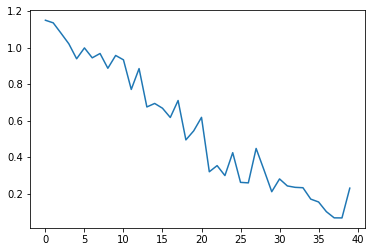

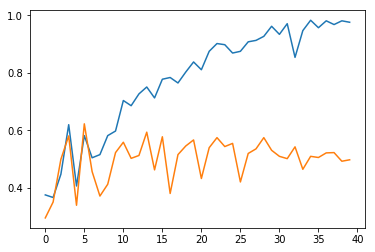

In [21]:
hidden_size = 256
encoder1 = EncoderRNN(lang.n_words, hidden_size)
decoder1 = Decoder(hidden_size,len(int2label))
ite = 2000

if use_cuda:
    encoder1 = encoder1.cuda()
    decoder1 = decoder1.cuda()

trainIters(train1, train2, encoder1, decoder1, ite, print_every=100, plot_every=50)

In [22]:
evaluateRandomly(train, encoder1, decoder1)

> New strategies against prostate cancer--Pt(II)-based chemotherapy.
= C2
< C2

> A prognostic index model for predicting overall survival in patients with metastatic castration-resistant prostate cancer treated with abiraterone acetate after docetaxel.
= A1
< A1

> The PREVAIL trial of enzalutamide in men with chemotherapy-naïve, metastatic castration-resistant prostate cancer: Post hoc analysis of Korean patients.
= E3
< E3

> Efficacy of docetaxel-based chemotherapy following ketoconazole in metastatic castration-resistant prostate cancer: implications for prior therapy in clinical trials.
= A1
< A1

> [Roles of enzalutamide in castrate-resistant prostate cancer].
= E3
< A1

> Cabazitaxel: more than a new taxane for metastatic castrate-resistant prostate cancer?
= C2
< C2

> Docetaxel followed by abiraterone in metastatic castration-resistant prostate cancer: efficacy and predictive parameters in a large single center cohort.
= A1
< A1

> [Treatment of metastatic castration-resistan

In [23]:
print(score(train1, encoder1, decoder1),score(train2, encoder1, decoder1))

0.984 0.507


In [28]:
labels = [evaluate(encoder1, decoder1, x) for x in test.title]

In [29]:
test2 = test.assign(label = labels)

In [30]:
test2

,pmid,year,title,abstract,label
0,21382150,2011,Current and emerging treatment modalities for ...,Docetaxel-based therapy is established as the ...,C2
1,27018069,2016,Enzalutamide in Japanese patients with chemoth...,"To evaluate the treatment effects, safety and ...",A1
2,24314736,2013,[Corticotherapy in castration-resistant prosta...,Corticosteroids are commonly used in the treat...,A1
3,25907622,2015,Clinical outcomes in a contemporary series of ...,The prognosis of younger patients with prostat...,E3
4,26633646,2015,Systemic Medical Treatment in Men with Metasta...,The approval or clinical evaluation of several...,C2
5,21743442,2011,Prostate cancer: Abiraterone increases overall...,,E3
6,27544577,2016,"Reply to Giandomenico Roviello, Daniele Genera...",,A1
7,27474149,2016,"Wedelolactone, an anti-inflammatory botanical,...",The c-Myc gene encodes an oncoprotein transcri...,E3
8,21076710,2010,"Cabazitaxel, a new taxane with favorable prope...",Cabazitaxel is a new taxane characterized by c...,E3
9,23436650,2013,The discovery of novel human androgen receptor...,Unraveling the mechanisms involved in castrati...,A1


In [31]:
test2.to_csv("./data_test_infer.csv")